<img style="float: left;" src="D2Klogo.png" width="20%"> 

<center>

# Welcome to DSCI 101 #
### Introduction to Data Science ###

### Analysis of a Data Set from DSCI 101 - Fall 2022 ###
    
- Contributors: Grant Thompson, Mac Tucker, Arjun Surya, Melinda Ma, Ruchi Tiwari, Arkin Si

<h1><center>Analyzation and Prediction of Variables Impact on Flight Cancellations and Delays</center></h1>

# Introduction

Since the early 2000s, the flight industry has grown tremendously, with the number of flights increasing by 69% and the number of scheduled passengers rising by 137% from 2004 to 2019. These figures highlight the prevalence of air travel in the lives of individuals with more people and more flights increasing daily. Air transportation is also the fastest and most costly mode of standard transport with prices that can range from a hundred to thousands of dollars. This promise of precise and speedy travel encourages consumers to spend extravagant amounts of money on flights. Therefore, the occurrence of delays and cancellations has immense negative consequences for flyers and the airlines. Many individuals schedule their amenities such as hotel bookings, car rentals, and event schedules around their perceived arrival times, and also depend on accurate timings to reach their connecting flights. Airlines that experience delays additionally face costs in terms of having to adjust airplane schedules that contribute to higher crew costs which ultimately are absorbed by consumers through more expensive plane tickets. Our flight delay analysis seeks to uncover the factors that provide flyers with the best information to make a timely and efficient journey. 

***Our Mission:***
- To provide consumers information about measurables/variables that may impact their flying experience
- We aim to inform consumers how airline carrier, day of the week, and flight distance affect their chances to experience a cancellation or significant delay

In [2]:
### Standard imports

import pandas as pd
import numpy as np
import math
import statsmodels.api as sm

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
plt.rcParams["patch.force_edgecolor"] = True

import seaborn as sns


import warnings
warnings.filterwarnings("ignore")

# Data and Data Exploration

The data that we examine comes from [the Bureau of Transportation Statistics](https://www7.bts.dot.gov/topics/airlines-and-airports-0), which collects large amounts of data on all airlines and airports in the United States. They record variables such as dates, flight arrival and departure times, plane characteristics, flight duration and distance, and reasons for delays and cancellations. A full list of variables is defined in the appendix. 

We specifically examine the flight records from the year 2008, which is the worst non-pandemic related year for profit margins since the 2000s due to the financial recession of the time period. Therefore, the results from the data can not be extrapolated to make definite conclusions for other years, but nevertheless it can point us in the right direction for trends to explore within more relevant data sets. As our analysis primarily deals with delays, we wanted to find delays at a significant level one at which the consumer would be inconvenienced. However, there was no defined variable for significant delays, so we found differences in actual arrival time and expected arrival time with those greater than 20 sorted as significant delays.  


##  Read data, create dataframes, and clean data

In [3]:
data_2008 = pd.read_csv("2008.csv")
data_2008.dtypes #everything looks like the right type
data_2008.isna().sum() #missing data for delays when there are no delays
#If there was no delay, set it to 0 minutes. If there is an NA in cancellation code, that means the flight was -
#'Not cancelled'
clean_data_2008 = data_2008.fillna({"CarrierDelay":0, "WeatherDelay":0, "NASDelay":0, "SecurityDelay": 0, 
                                   "LateAircraftDelay": 0, "CancellationCode": "Not Cancelled"})
clean_data_2008.drop(columns = ["Cancelled", "FlightNum"], inplace = True)
#Rename some of the data to make it easier to read, changing numbers to their respective weekdays, etc
clean_data_2008["Diverted"].replace({0:False, 1:True}, inplace = True)
clean_data_2008['DayOfWeek'].replace({1:'1_Monday', 2:'2_Tuesday',3:'3_Wednesday',4:'4_Thursday',5:'5_Friday',6:'6_Saturday',7:'7_Sunday'}, inplace = True)
clean_data_2008['UniqueCarrier'].replace({'AA':'1_AA'}, inplace = True)
clean_data_2008

,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,TailNum,...,Distance,TaxiIn,TaxiOut,CancellationCode,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
0,2008,1,3,4_Thursday,1343.0,1325,1451.0,1435,WN,N240WN,...,393,4.0,9.0,Not Cancelled,False,16.0,0.0,0.0,0.0,0.0
1,2008,1,3,4_Thursday,1125.0,1120,1247.0,1245,WN,N523SW,...,441,3.0,8.0,Not Cancelled,False,0.0,0.0,0.0,0.0,0.0
2,2008,1,3,4_Thursday,2009.0,2015,2136.0,2140,WN,N280WN,...,441,2.0,14.0,Not Cancelled,False,0.0,0.0,0.0,0.0,0.0
3,2008,1,3,4_Thursday,903.0,855,1203.0,1205,WN,N308SA,...,848,5.0,7.0,Not Cancelled,False,0.0,0.0,0.0,0.0,0.0
4,2008,1,3,4_Thursday,1423.0,1400,1726.0,1710,WN,N462WN,...,848,6.0,10.0,Not Cancelled,False,16.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2389212,2008,4,17,4_Thursday,1025.0,1025,1234.0,1237,DL,N393DA,...,752,5.0,16.0,Not Cancelled,False,0.0,0.0,0.0,0.0,0.0
2389213,2008,4,17,4_Thursday,1319.0,1320,1527.0,1524,DL,N952DL,...,752,9.0,12.0,Not Cancelled,False,0.0,0.0,0.0,0.0,0.0
2389214,2008,4,17,4_Thursday,1335.0,1335,1556.0,1553,DL,N392DA,...,752,7.0,31.0,Not Cancelled,False,0.0,0.0,0.0,0.0,0.0
2389215,2008,4,17,4_Thursday,1933.0,1935,2140.0,2141,DL,N3756,...,752,9.0,12.0,Not Cancelled,False,0.0,0.0,0.0,0.0,0.0


In [4]:
#Creating a new column to represent if a flight was significantly delayed or not (delay over 20 min)
clean_data_2008['SignificantArrivalDelay'] = np.where((clean_data_2008['ActualElapsedTime']) - (clean_data_2008['CRSElapsedTime']) >= 20, True, False)
clean_data_2008[clean_data_2008['SignificantArrivalDelay'] == True]
clean_data_2008['CancellationCode'].replace({'A' : 'Carrier', 'B':'Weather','C':'NAS', 'D':'Security'}, inplace = True)
clean_data_2008[clean_data_2008['SignificantArrivalDelay'] == True]
clean_data_2008['TotalDelay'] = clean_data_2008['ActualElapsedTime'] - clean_data_2008['CRSElapsedTime']
#test = clean_data_2008[['TotalDelay', 'ArrTime', 'CRSArrTime']]
#test[test['TotalDelay'] > 2000]

## Data exploration

Our analysis of the data set aimed to provide necessary information to protect the average flight consumer. We aimed to inform them which airline carriers or other variables had the biggest effect on a flight's total delay or cancellation. We decided to check how often a flight experienced a cancellation or significant delay to see if it was significant enough of a number to further analyze its possible causations.

In [5]:
cancelled_flights_num = clean_data_2008[clean_data_2008['CancellationCode'] != 'Not Cancelled'].shape[0]
delayed_flights_num = clean_data_2008[clean_data_2008['SignificantArrivalDelay'] == True].shape[0]

percentage_flights_delayed_cancelled = ((cancelled_flights_num + delayed_flights_num) / clean_data_2008.shape[0]) * 100
print(round(percentage_flights_delayed_cancelled, 2),'% of all flights were significantly delayed or cancelled')

8.76 % of all flights were significantly delayed or cancelled


In [6]:
print(
    (clean_data_2008['SignificantArrivalDelay'] == True).sum(), 'flights out of', + clean_data_2008.shape[0], 'flights were significantly delayed in 2008' )

144941 flights out of 2389217 flights were significantly delayed in 2008


###  Univariate Analysis

To begin the exploratory data analysis, we found the percentage of flights that experienced arrival delays or cancellations. Approximately 9% of all flights were canceled or significantly delayed. Next, we explored the distribution of cancellation codes using a pie chart. We found that the largest portion of cancellations were caused by the carrier. Therefore, we could conclude that an airline carrier has the largest impact on whether or not a flight will be canceled, when compared to the other 3 types of delays.

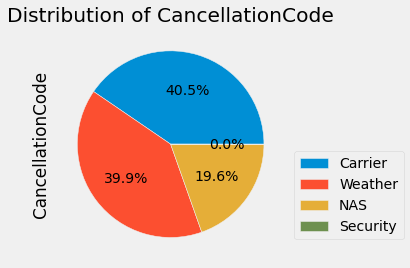

In [7]:
#Pie chart comparing the percentages of reasons flights were cancelled
col = 'CancellationCode'
df = clean_data_2008[clean_data_2008['CancellationCode'] != 'Not Cancelled']
title = "Distribution of "+col
pie = df[col].value_counts().plot(kind='pie', autopct = '%1.1f%%', title = title, labeldistance = None);
pie.legend(['Carrier','Weather','NAS','Security'], bbox_to_anchor = [1,.5])

num_security = clean_data_2008[clean_data_2008['CancellationCode'] == 'Security'].shape[0]
# 6 total security delays, but the number is rounded down to 0% within the pie chart

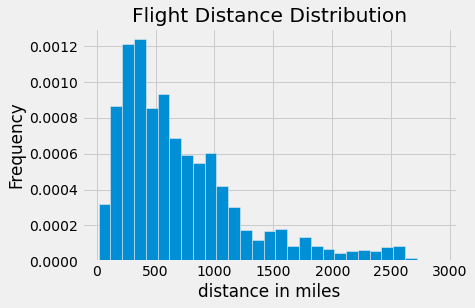

In [8]:
#Charting the distribution of flight distances
flight_length = clean_data_2008['Distance']
[min(flight_length), max(flight_length)]
fl_bins = range(min(flight_length), 3000, 100)
flight_length.plot(kind='hist', bins=fl_bins, density=True, title='Flight Distance Distribution').set_xlabel('distance in miles');

### Bivariate Analysis

We were motivated to analyze flight cancellation and significant delays with other variables to find any correlations. By analyzing these two variables with other measurables, we were able to effectively display information that could be shared to flight consumers, helping them make decisions to achieve the best user experience while flying.

<AxesSubplot:title={'center':'Cancelled Flights for each Day of the Week'}, xlabel='Day'>

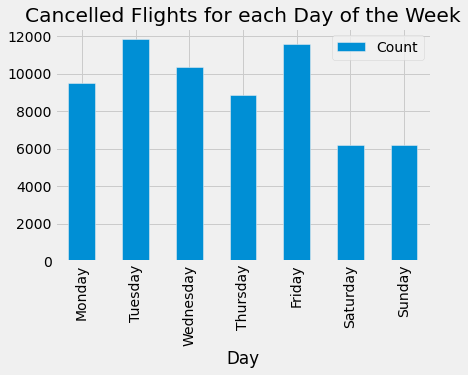

In [9]:
# cancelled flights for each day of the week
test_df=clean_data_2008[clean_data_2008['CancellationCode'] != 'Not Cancelled']

# cancelled flights for each day of the week
days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
cancellations_DoW = test_df['DayOfWeek'].value_counts().to_frame().sort_index()
cancellations_DoW['Day'] = days
cancellations_DoW.rename(columns={'DayOfWeek':'Count'}, inplace=True)
cancellations_DoW.plot(kind='bar', x='Day', y='Count', title='Cancelled Flights for each Day of the Week')

<AxesSubplot:title={'center':'Amount of Significant Delays for each Day of the Week'}, xlabel='Day'>

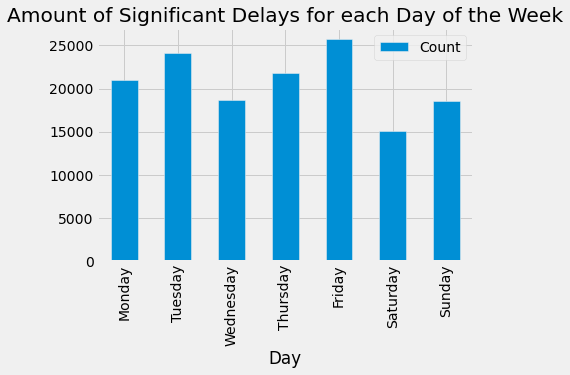

In [10]:
#delayed flights for each day of the week
delays_DoW = clean_data_2008[clean_data_2008['SignificantArrivalDelay'] == True]['DayOfWeek'].value_counts().to_frame().sort_index()
delays_DoW['Day'] = days
delays_DoW.rename(columns={'DayOfWeek':'Count'}, inplace=True)
delays_DoW.plot(kind='bar', x='Day', y='Count', title='Amount of Significant Delays for each Day of the Week')


<AxesSubplot:title={'center':'Relationship between Distance and Total Delay'}, xlabel='Distance', ylabel='TotalDelay'>

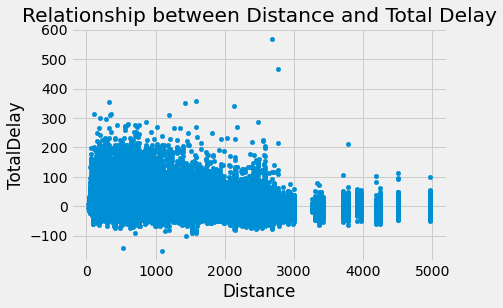

In [11]:
clean_data_2008.plot(kind = 'scatter', x='Distance', y='TotalDelay', title = 'Relationship between Distance and Total Delay')

<AxesSubplot:title={'center':'Relationship between Distance and Departure Delay'}, xlabel='Distance', ylabel='DepDelay'>

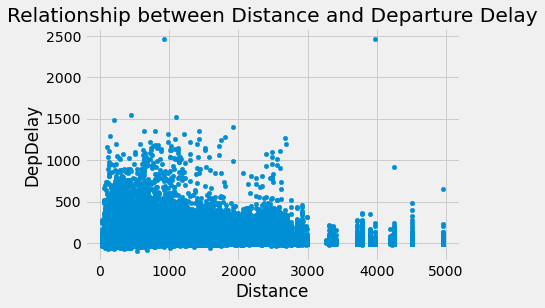

In [12]:
#Relationship between distance of flight and delay experieced
clean_data_2008.plot(kind = 'scatter', x='Distance', y='DepDelay', title = 'Relationship between Distance and Departure Delay')

<AxesSubplot:title={'center':'Carriers with the Most Cancelled Flights'}, xlabel='UniqueCarrier'>

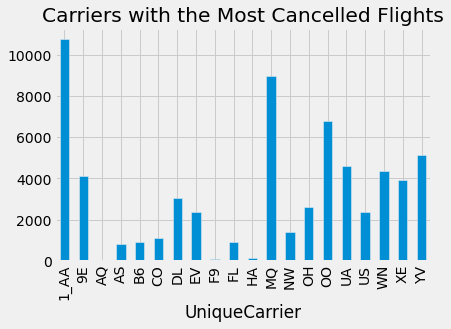

In [13]:
cancelled_flights_plot = clean_data_2008[clean_data_2008['CancellationCode'] != 'Not Cancelled'][['CancellationCode', 'UniqueCarrier', 'Year']]

cancelled_flights_plot['CancellationCode'] = True



index = 'UniqueCarrier'
column = 'CancellationCode'
values = 'Year'
aggfunc = 'count'
df = cancelled_flights_plot
title = "Carriers with the Most Cancelled Flights"

df_plot = df.pivot_table(index = index, columns = column, values = values, aggfunc = aggfunc)
df_plot.plot(kind = 'bar', title = title, legend = False)

<AxesSubplot:title={'center':'Top 5 Airlines with the Highest Proportion of Flights Cancelled'}, xlabel='UniqueCarrier'>

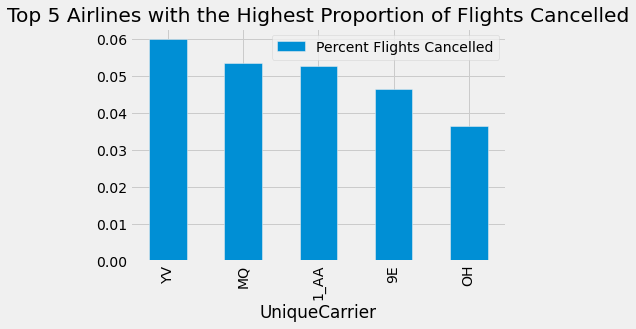

In [14]:
# cancellation percentage of different airlines
flights_cancelled_airlines = clean_data_2008[clean_data_2008['CancellationCode'] != 'Not Cancelled'][['UniqueCarrier']]
flights_cancelled_airlines['Count'] = 0
flights_total_airlines = clean_data_2008[['UniqueCarrier']]
flights_total_airlines['Count'] = 0
carriers_total = flights_total_airlines.groupby(['UniqueCarrier']).count()
carriers_cancelled = flights_cancelled_airlines.groupby(['UniqueCarrier']).count()
carriers_cancelled['Percent Flights Cancelled'] = carriers_cancelled['Count'] / carriers_total['Count']
index = 'UniqueCarrier'
column = 'Percent Flights Cancelled'
aggfunc = 'count'
top_num = 5
title= 'Top 5 Airlines with the Highest Proportion of Flights Cancelled'
highest_cancellations = carriers_cancelled.pivot_table(index=index, values = column).sort_values(by=column, ascending=False).head(top_num)
highest_cancellations.plot(kind='bar', title=title)

<AxesSubplot:title={'center':'Top 5 Airlines with the Highest Proportion of Flights With Significant Delays'}, xlabel='UniqueCarrier'>

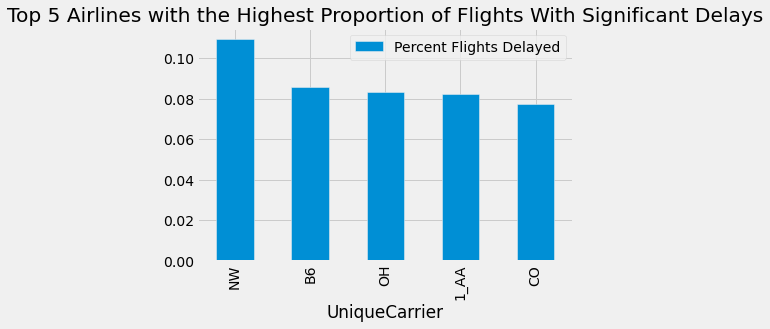

In [15]:
flights_delayed_airlines1 = clean_data_2008[clean_data_2008['SignificantArrivalDelay'] == True][['UniqueCarrier']]
flights_delayed_airlines1['Count'] = 0
flights_total_airlines1 = clean_data_2008[['UniqueCarrier']]
flights_total_airlines1['Count'] = 0
carriers_total1 = flights_total_airlines1.groupby(['UniqueCarrier']).count()
carriers_delayed1 = flights_delayed_airlines1.groupby(['UniqueCarrier']).count()
carriers_delayed1['Percent Flights Delayed'] = carriers_delayed1['Count'] / carriers_total1['Count']
index = 'UniqueCarrier'
column = 'Percent Flights Delayed'
aggfunc = 'count'
top_num = 5
title= 'Top 5 Airlines with the Highest Proportion of Flights With Significant Delays'
highest_delays = carriers_delayed1.pivot_table(index=index, values = column).sort_values(by=column, ascending=False).head(top_num)
highest_delays.plot(kind='bar', title=title)

**Conclusions**:
- The weekends experience the least amount of delays and cancellations. Flying on the weekends is a better option for consumers who wish to avoid significant delays or cancellations.
- Fridays are the most risky day to fly in regards to significant delays and cancellations
- There seems to be little to no correlation between a flights distance and it's overall delay time
- American airlines and Envoy air have the most amount of canceled flights
- YV, MQ, and AA have the highest proportion of their flights canceled
- NW, B6, and OH have the highest proportion of their flights delayed

# Methods and Models

**Correlation:**

In [16]:
clean_data_2008.corr()
#Weak correlation between a majority of variables that are not directly connected (such as departure delay and total delay)

,Year,Month,DayofMonth,DepTime,CRSDepTime,ArrTime,CRSArrTime,ActualElapsedTime,CRSElapsedTime,AirTime,...,TaxiIn,TaxiOut,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay,SignificantArrivalDelay,TotalDelay
Year,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Month,NaN,1.000000,-0.005349,-0.005991,-0.001914,-0.007743,-0.005156,-0.005157,-0.001338,-0.000222,...,-0.016274,-0.024323,-0.004012,-0.011147,-0.011119,-0.017451,-0.002707,-0.025436,-0.020169,-0.007841
DayofMonth,NaN,-0.005349,1.000000,-0.002672,-0.000955,0.000059,-0.001015,-0.003658,-0.002735,-0.002001,...,-0.015671,-0.004325,-0.006037,-0.013948,-0.009498,-0.002484,-0.004640,-0.014375,-0.006242,-0.003754
DepTime,NaN,-0.005991,-0.002672,1.000000,0.967003,0.699717,0.782824,-0.023956,-0.016938,-0.024520,...,-0.038160,0.014631,-0.003855,0.063312,0.031367,0.059092,0.003081,0.174164,-0.011204,-0.035300
CRSDepTime,NaN,-0.001914,-0.000955,0.967003,1.000000,0.682548,0.782391,-0.022142,-0.014047,-0.020576,...,-0.042455,0.003800,-0.006720,0.019744,0.013831,0.020496,0.000799,0.134700,-0.021260,-0.044842
ArrTime,NaN,-0.007743,0.000059,0.699717,0.682548,1.000000,0.857358,0.029097,0.032263,0.025493,...,0.007492,0.025680,NaN,0.009224,0.005091,0.051998,0.001211,0.050918,0.006820,-0.014436
CRSArrTime,NaN,-0.005156,-0.001015,0.782824,0.782391,0.857358,1.000000,0.040200,0.048437,0.038249,...,-0.006040,0.024236,0.001678,0.017721,0.014511,0.035035,0.000793,0.121887,-0.007541,-0.038622
ActualElapsedTime,NaN,-0.005157,-0.003658,-0.023956,-0.022142,0.029097,0.040200,1.000000,0.979426,0.984988,...,0.154481,0.259007,NaN,0.016707,0.004944,0.142827,0.003484,0.006649,0.200041,0.138708
CRSElapsedTime,NaN,-0.001338,-0.002735,-0.016938,-0.014047,0.032263,0.048437,0.979426,1.000000,0.987684,...,0.100704,0.134900,0.016277,0.009947,-0.010605,0.042291,0.001643,-0.001715,0.069093,-0.063996
AirTime,NaN,-0.000222,-0.002001,-0.024520,-0.020576,0.025493,0.038249,0.984988,0.987684,1.000000,...,0.081652,0.103036,NaN,0.009005,-0.010005,0.065250,0.002628,-0.002953,0.111380,0.023946


## Hypothesis testing


**Null Hypothesis**: American Airlines has the same delay proportion as the entire population

**Alternative Hypothesis**:  American Airlines has a higher proportion of delays than the rest of the population.

**Alpha Value**: We are choosing the significance level alpha to be 5%

The next step in our data analysis was to come up with a hypothesis to test. Our goal was to demonstrate the differences in delay time between carriers. To do so, we chose one of the most popular airline carriers, American Airlines. American Airlines was also one of the top 5 carriers in significant delays, as we found in our bivariate analysis. Our aim was to provide consumers information about carriers that may or may not experience a larger amount of delays than others.

In [17]:
#Creating dataframe for American Airlines Flights
AA = clean_data_2008[(clean_data_2008['UniqueCarrier']=='1_AA')]
delayed_AA= clean_data_2008[(clean_data_2008['UniqueCarrier'] == '1_AA') &  ((clean_data_2008['SignificantArrivalDelay'] == True ))]
observed_stat = len(delayed_AA)/len(AA)
observed_stat
delayed_AA

,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,TailNum,...,TaxiOut,CancellationCode,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay,SignificantArrivalDelay,TotalDelay
477153,2008,1,11,5_Friday,854.0,900,1241.0,1225,1_AA,N332AA,...,73.0,Not Cancelled,False,0.0,0.0,16.0,0.0,0.0,True,22.0
477161,2008,1,19,6_Saturday,852.0,900,1241.0,1225,1_AA,N335AA,...,56.0,Not Cancelled,False,0.0,0.0,16.0,0.0,0.0,True,24.0
477169,2008,1,27,7_Sunday,859.0,900,1257.0,1225,1_AA,N327AA,...,47.0,Not Cancelled,False,0.0,0.0,32.0,0.0,0.0,True,33.0
477184,2008,1,11,5_Friday,1028.0,930,2000.0,1750,1_AA,N320AA,...,73.0,Not Cancelled,False,0.0,0.0,130.0,0.0,0.0,True,72.0
477186,2008,1,13,7_Sunday,931.0,930,1811.0,1750,1_AA,N323AA,...,17.0,Not Cancelled,False,0.0,0.0,21.0,0.0,0.0,True,20.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2312928,2008,4,23,3_Wednesday,2248.0,2215,143.0,2330,1_AA,N3BFAA,...,103.0,Not Cancelled,False,0.0,33.0,100.0,0.0,0.0,True,100.0
2312934,2008,4,29,2_Tuesday,2215.0,2215,2353.0,2330,1_AA,N3CPAA,...,19.0,Not Cancelled,False,0.0,0.0,23.0,0.0,0.0,True,23.0
2312962,2008,4,22,2_Tuesday,947.0,945,1224.0,1110,1_AA,N4YAAA,...,36.0,Not Cancelled,False,0.0,0.0,74.0,0.0,0.0,True,72.0
2312963,2008,4,23,3_Wednesday,951.0,945,1139.0,1110,1_AA,N593AA,...,43.0,Not Cancelled,False,0.0,0.0,29.0,0.0,0.0,True,23.0


In [18]:
#Sampling American Airlines to find 
k = len(AA)
sample = clean_data_2008.sample(k)
delayed_sample = sample[(sample['SignificantArrivalDelay'] == True)]
one_simu_stat= len(delayed_sample)/k
one_simu_stat

0.06064473227426303

In [19]:
# Simulating Test Statistic Under the Null
simu_stats = []
rep = 1000
sample_size = len(AA)

for i in np.arange(rep):
    sample = clean_data_2008.sample(sample_size)
    delayed_sample = sample[(sample['SignificantArrivalDelay'] == True)]
    one_simulated_stat= len(delayed_sample)/(sample_size)
    simu_stats = np.append(simu_stats, one_simulated_stat)
    
sum(simu_stats) / len(simu_stats)

0.060673399537451295

Text(0, 0.5, 'Count')

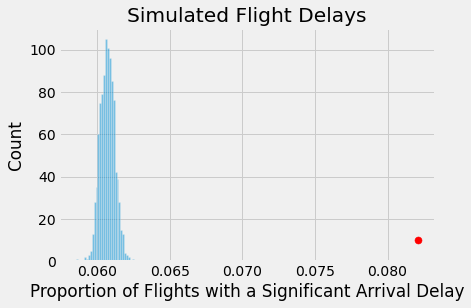

In [20]:
# visualization
plt.hist(simu_stats, bins=30, alpha=0.5)
plt.scatter(observed_stat, 10, color='red', s=50);
plt.title('Simulated Flight Delays')
plt.xlabel('Proportion of Flights with a Significant Arrival Delay')
plt.ylabel('Count')

In [21]:
# calculate p-value
pvalue = np.average(simu_stats >= observed_stat)
pvalue
#print(sum(simu_stats) / len(simu_stats))

0.0

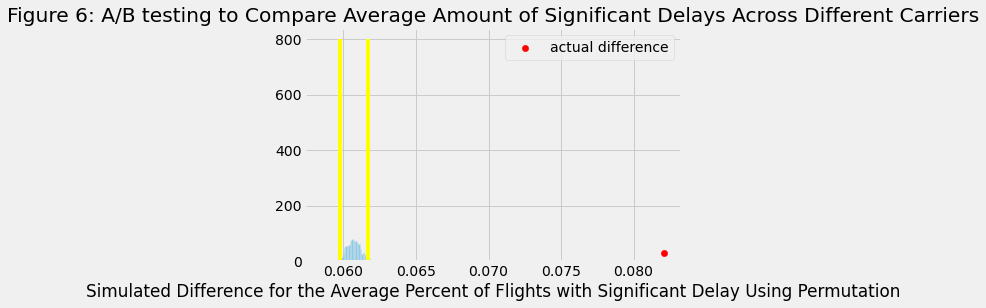

In [22]:
alpha = 0.05
#calculate upper percentile cutoff
cut_off_l = np.percentile(simu_stats, 100*alpha/2)
cut_off_r = np.percentile(simu_stats, 100*(1-alpha/2))
#visualize the simulated statistics list as a histogram
plt.hist(simu_stats, bins=40, alpha=0.4)
#visualize the observed statistic as a red point
plt.scatter(observed_stat, 30, color='red', s=40, label='actual difference')
#visualize the cutoff point as a yellow line
plt.plot([cut_off_l,cut_off_l],[0,800], color='yellow')
plt.plot([cut_off_r,cut_off_r],[0,800], color='yellow')
plt.legend()
plt.xlabel('Simulated Difference for the Average Percent of Flights with Significant Delay Using Permutation')
plt.title('Figure 6: A/B testing to Compare Average Amount of Significant Delays Across Different Carriers');

**Conclusion**: 
- Since our p-value is 0.0, which is less than the alpha value of 0.05 for statistical significance, we can reject the null hypothesis that American Airlines has the same delay proportion as the rest of the population.
- This is significant in our mission to help provide information consumers could use to gain a better user experience.

From our test, we determined that American Airlines has a proportion of 8.2% of flights significantly delayed compared to the overall proportion of 6.1% of flights. When conducting a simulation to create a sample statistic, we determined that after 1000 repetitions, our difference was significant at the P value of 0.00. Since this is less than our initial alpha level of .05, we concluded that we can reject the null hypothesis that the true proportions of delays are the same. 

## Linear Regression

- Question:
    - Does airline carrier, flight distance, or day of week have an effect on a flight's total delay?

We wanted to explore how certain variables impact a flight's total delay time. In doing so, we could present this information to flight consumers to inform them how certain carriers, flying on specific days, or what distances of flights have the most impact on reducing their total delay times. 

In [23]:
#Creating the linear model
model3 = sm.OLS.from_formula('TotalDelay ~ C(DayOfWeek) + C(UniqueCarrier) + Distance', data=clean_data_2008)
result3 = model3.fit()
result3.summary()
#American Airlines baseline
#Monday baseline

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             TotalDelay   R-squared:                       0.029
Model:                            OLS   Adj. R-squared:                  0.029
Method:                 Least Squares   F-statistic:                     2622.
Date:                Sat, 28 Jan 2023   Prob (F-statistic):               0.00
Time:                        12:49:44   Log-Likelihood:            -9.4113e+06
No. Observations:             2319121   AIC:                         1.882e+07
Df Residuals:                 2319094   BIC:                         1.882e+07
Df Model:                          26                                         
Covariance Type:            nonrobust                                         
===============================================================================================
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept                       2.4849      0.043     57.126      0.000       2.400       2.570
C(DayOfWeek)[T.2_Tuesday]       0.5123      0.034     15.125      0.000       0.446       0.579
C(DayOfWeek)[T.3_Wednesday]    -0.5206      0.034    -15.462      0.000      -0.587      -0.455
C(DayOfWeek)[T.4_Thursday]      0.3298      0.034      9.696      0.000       0.263       0.396
C(DayOfWeek)[T.5_Friday]        0.9741      0.034     28.596      0.000       0.907       1.041
C(DayOfWeek)[T.6_Saturday]     -1.3957      0.036    -39.026      0.000      -1.466      -1.326
C(DayOfWeek)[T.7_Sunday]       -0.5978      0.035    -17.322      0.000      -0.665      -0.530
C(UniqueCarrier)[T.9E]         -3.3409      0.059    -56.638      0.000      -3.456      -3.225
C(UniqueCarrier)[T.AQ]         -3.0101      0.163    -18.509      0.000      -3.329      -2.691
C(UniqueCarrier)[T.AS]         -2.3466      0.071    -33.085      0.000      -2.486      -2.208
C(UniqueCarrier)[T.B6]         -2.4126      0.063    -38.292      0.000      -2.536      -2.289
C(UniqueCarrier)[T.CO]         -1.5073      0.054    -27.749      0.000      -1.614      -1.401
C(UniqueCarrier)[T.DL]         -0.8410      0.048    -17.364      0.000      -0.936      -0.746
C(UniqueCarrier)[T.EV]         -4.0062      0.058    -69.484      0.000      -4.119      -3.893
C(UniqueCarrier)[T.F9]         -0.1570      0.086     -1.820      0.069      -0.326       0.012
C(UniqueCarrier)[T.FL]          0.2188      0.058      3.784      0.000       0.105       0.332
C(UniqueCarrier)[T.HA]         -1.0338      0.109     -9.511      0.000      -1.247      -0.821
C(UniqueCarrier)[T.MQ]         -1.3583      0.049    -27.729      0.000      -1.454      -1.262
C(UniqueCarrier)[T.NW]          2.3034      0.052     44.684      0.000       2.202       2.404
C(UniqueCarrier)[T.OH]         -1.3626      0.063    -21.654      0.000      -1.486      -1.239
C(UniqueCarrier)[T.OO]         -0.8937      0.047    -19.079      0.000      -0.985      -0.802
C(UniqueCarrier)[T.UA]         -2.0168      0.048    -41.784      0.000      -2.111      -1.922
C(UniqueCarrier)[T.US]         -4.7332      0.048    -98.061      0.000      -4.828      -4.639
C(UniqueCarrier)[T.WN]         -5.4921      0.040   -138.215      0.000      -5.570      -5.414
C(UniqueCarrier)[T.XE]         -1.5842      0.051    -31.368      0.000      -1.683      -1.485
C(UniqueCarrier)[T.YV]         -1.8378      0.060    -30.599      0.000      -1.956      -1.720
Distance                       -0.0019   1.84e-05   -104.054      0.000      -0.002      -0.002
==============================================================================
Omnibus:                  1347774.019   Durbin-Watson:                   1.681
Prob(Omnibus):                  0.000   Jarqu

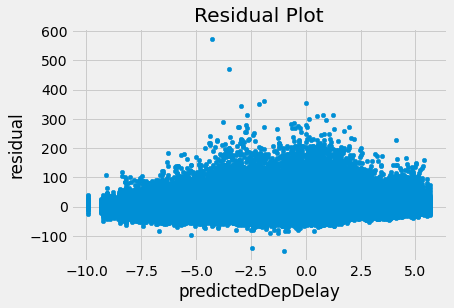

In [24]:
clean_data_2008['predictedDepDelay'] = result3.fittedvalues
clean_data_2008['residual'] = result3.resid
clean_data_2008.plot(kind = 'scatter', x ='predictedDepDelay', y= 'residual' )
plt.title('Residual Plot');

**Conclusion:**
- Interpretation of model results:
     - For the days of the week, Monday was the baseline. Therefore, for a day like Friday, the average duration of total delay is 1 minute more when compared to the average duration of departure delay on monday.
      - For the carriers, American Airlines, AA, is the baseline. Therefore, for a carrier like JetBlue, the average duration of departure delay is 2.5 minutes less when compared to the average duration of departure delay of American Airlines.
      - For distance, when the distance increases by 1 mile, the average duration of total delay decreases by 0.0019 minutes. With a correlation this low, we can come to a conclusion that a change in distance has relatively no impact on a flight's total delay time.
- $R^2$ and its interpretation:
    - $R^2$ value is 0.029, therefore 2.9% of the variability in departure delay is explained by the regression model
- Answer to the proposed data question:
    - Since the R^2 value is so low, we are not able to say that Airline Carrier, flight distance, or day of the week have a significant impact on the duration of departure delays. However, we were able to compare the differences in departure delay between days of the week and carriers. For example, we can see that Fridays experience the highest average departure delay when compared to Mondays.

## Logistic Regression

Next, we wanted to analyze the correlation between a few variables and a flight's cancellation. We asked the question:
- Do flight distance, day of the week, airline carrier, or scheduled arrival/departure/elapsed time have a significant impact on a Flights chance to be cancelled?

We thought finding evidence of correlation between cancellation and any of these variables would be vital in our mission to provide consumers the needed information to provide themselves the best flight experience. For example, if airline carrier and cancellation had a significant correlation, we could point consumers in the direction of certain carriers and away from others. 

To achieve this model, we created a new column composed of 1's and 0's, which represented if a flight was not cancelled (0) or cancelled (1).

In [25]:
#Creating new cancelled/not cancelled row
def categorise(row):  
    if row['CancellationCode'] == 'Not Cancelled':
        return 0
    else:
        return 1 

clean_data_2008['Cancelled'] = clean_data_2008.apply(lambda row: categorise(row), axis = 1)
#clean_data_2008

In [26]:
#Creating the logistic model
model2 = sm.GLM.from_formula('Cancelled ~ Distance + C(DayOfWeek) + C(UniqueCarrier) + CRSArrTime + CRSDepTime + CRSElapsedTime', 
                             family=sm.families.Binomial(), data=clean_data_2008)
result2 = model2.fit()
result2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              Cancelled   No. Observations:              2388810
Model:                            GLM   Df Residuals:                  2388780
Model Family:                Binomial   Df Model:                           29
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -2.7910e+05
Date:                Sat, 28 Jan 2023   Deviance:                   5.5819e+05
Time:                        12:51:07   Pearson chi2:                 2.48e+06
No. Iterations:                     9   Pseudo R-squ. (CS):            0.01401
Covariance Type:            nonrobust                                         
===============================================================================================
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept                      -3.1912      0.025   -129.698      0.000      -3.239      -3.143
C(DayOfWeek)[T.2_Tuesday]       0.1943      0.014     13.775      0.000       0.167       0.222
C(DayOfWeek)[T.3_Wednesday]     0.0377      0.015      2.596      0.009       0.009       0.066
C(DayOfWeek)[T.4_Thursday]     -0.0815      0.015     -5.397      0.000      -0.111      -0.052
C(DayOfWeek)[T.5_Friday]        0.1979      0.014     13.950      0.000       0.170       0.226
C(DayOfWeek)[T.6_Saturday]     -0.2258      0.017    -13.546      0.000      -0.258      -0.193
C(DayOfWeek)[T.7_Sunday]       -0.3919      0.017    -23.527      0.000      -0.424      -0.359
C(UniqueCarrier)[T.9E]         -0.6140      0.020    -30.953      0.000      -0.653      -0.575
C(UniqueCarrier)[T.AQ]         -2.4602      0.155    -15.837      0.000      -2.765      -2.156
C(UniqueCarrier)[T.AS]         -1.2582      0.037    -34.006      0.000      -1.331      -1.186
C(UniqueCarrier)[T.B6]         -1.5501      0.035    -43.994      0.000      -1.619      -1.481
C(UniqueCarrier)[T.CO]         -1.7623      0.032    -54.574      0.000      -1.826      -1.699
C(UniqueCarrier)[T.DL]         -1.1715      0.021    -55.768      0.000      -1.213      -1.130
C(UniqueCarrier)[T.EV]         -1.1317      0.024    -47.721      0.000      -1.178      -1.085
C(UniqueCarrier)[T.F9]         -2.8554      0.102    -28.079      0.000      -3.055      -2.656
C(UniqueCarrier)[T.FL]         -1.7976      0.035    -51.322      0.000      -1.866      -1.729
C(UniqueCarrier)[T.HA]         -2.2415      0.096    -23.402      0.000      -2.429      -2.054
C(UniqueCarrier)[T.MQ]         -0.3828      0.016    -24.300      0.000      -0.414      -0.352
C(UniqueCarrier)[T.NW]         -1.7653      0.029    -61.377      0.000      -1.822      -1.709
C(UniqueCarrier)[T.OH]         -0.8786      0.023    -38.004      0.000      -0.924      -0.833
C(UniqueCarrier)[T.OO]         -0.7861      0.017    -46.894      0.000      -0.819      -0.753
C(UniqueCarrier)[T.UA]         -0.6185      0.018    -34.327      0.000      -0.654      -0.583
C(UniqueCarrier)[T.US]         -1.5011      0.023    -64.798      0.000      -1.546      -1.456
C(UniqueCarrier)[T.WN]         -1.7723      0.019    -95.079      0.000      -1.809      -1.736
C(UniqueCarrier)[T.XE]         -0.9742      0.019    -50.043      0.000      -1.012      -0.936
C(UniqueCarrier)[T.YV]         -0.2647      0.018    -14.352      0.000      -0.301      -0.229
Distance                       -0.0027   4.41e-05    -61.625      0.000      -0.003      -0.003
CRSArrTime                      0.0002    2.1e-05      9.617      0.000       0.000       0.000
CRSDepTime                  -1.821e-05   2.15e-05     -0.846      0.397   -6.04e-05     2.4e-05
CRSElapsedT

In [27]:
# convert log odds ratio to odds ratio 
# by taking exp of parameters
print(np.round(np.exp(result2.params),3))

Intercept                      0.041
C(DayOfWeek)[T.2_Tuesday]      1.215
C(DayOfWeek)[T.3_Wednesday]    1.038
C(DayOfWeek)[T.4_Thursday]     0.922
C(DayOfWeek)[T.5_Friday]       1.219
C(DayOfWeek)[T.6_Saturday]     0.798
C(DayOfWeek)[T.7_Sunday]       0.676
C(UniqueCarrier)[T.9E]         0.541
C(UniqueCarrier)[T.AQ]         0.085
C(UniqueCarrier)[T.AS]         0.284
C(UniqueCarrier)[T.B6]         0.212
C(UniqueCarrier)[T.CO]         0.172
C(UniqueCarrier)[T.DL]         0.310
C(UniqueCarrier)[T.EV]         0.322
C(UniqueCarrier)[T.F9]         0.058
C(UniqueCarrier)[T.FL]         0.166
C(UniqueCarrier)[T.HA]         0.106
C(UniqueCarrier)[T.MQ]         0.682
C(UniqueCarrier)[T.NW]         0.171
C(UniqueCarrier)[T.OH]         0.415
C(UniqueCarrier)[T.OO]         0.456
C(UniqueCarrier)[T.UA]         0.539
C(UniqueCarrier)[T.US]         0.223
C(UniqueCarrier)[T.WN]         0.170
C(UniqueCarrier)[T.XE]         0.377
C(UniqueCarrier)[T.YV]         0.767
Distance                       0.997
C

In [28]:
#Creating the decision matrix
clean_data_2008['pred1'] = (result2.fittedvalues>0.5)*1
clean_data_2008.pivot_table(index='Cancelled', columns='pred1', 
                  values='Year', aggfunc='count')

pred1,0.0,1.0
Cancelled,,
0,2324486,1
1,64321,2


**Conclusion**:
- We got an pseudo $R^2$ value of 0.01401, which is significantly less than 1. This implies that, with the variables used in the model, our model accounts for 1.4% of the variability in a flight's cancellation.
- In addition, our model correctly predicted 97% of the 'Not Cancelled' Flights. However, this percentage is a bit misleading.
- Our model is quite inaccurate in predicting whether or not a flight will be cancelled, as seen in our confusion matrix, we had 2.32 million true positives, but 64,321 false positives. This may seem like an accurate model, however, it predicted that every single flight, except for 3, would not be cancelled. While in reality, over 64,000 flights were cancelled within the dataset. Our model was only successful in predicting such a high number of correct 'Not Cancelled' flights because the majority of the flights in the data set were not cancelled. If given a data set of flights from the previous year, the model would perform poorly in predicting cancelled vs. not cancelled flights.

# Results

The results of our investigation are both broad and intersect several stages of the data science pipeline:

## Data Analysis
Through both our bivariate analysis and hypothesis testing, we determined that there is a significant difference between the number of delays that American Airlines has compared to other airline carriers. As such, we can conclude with confidence that during 2008, American Airlines performed the worst in this category, specifically compared to its competitors. We were able to highlight carriers that experienced more significant delays and cancellations in comparison to their competitors. Additionally, we were not able to find a significant correlation between a flights distance and its total delay time.

## Modeling and Prediction
Unfortunately, our models, both linear and logistic, were rather inaccurate. However, we were able to reject the null hypothesis that 'American Airlines has the same delay proportion as the entire population.' In doing so, we came to the conclusion to recommend against American Airlines if a consumer is looking to minimize the possibility of significant delays.

In both our models, linear and logistic, we were not able to find significant correlations between the data. In our correlation table, the only variables with strong correlation with each other are directly connected. For example, TaxiIn and TaxiOut time have a strong effect on total elapsed time since those measurements would be included in the total time. Variables like Distance, UniqueCarrier, and DayOfWeek had a very weak correlation with our total delay and cancellation variables.

This weak correlation led to rather inaccurate models. Our logistic model had a rather high accuracy percentage, however this was due to the model consistently predicting 'Not Cancelled' for every flight, in which a large proportion of total flights were not cancelled to begin with. Our linear regression model was also rather inaccurate. It had a low $R^2$ value of 0.029. However, we could still use this model to compare the effects of switching from one carrier to another, or flying on one day of the week compared to another.

# Discussion

Since our dataset comes from 2008, this is significant in our overall conclusions as well. Due to the financial recession, 2008 had the worst year for profit margins in the airline industry before the pandemic. As a result, the prevalence of flight cancellations and delays for especially harmed companies might be higher than what it is today after recovery. Thus, because our data comes from such a unique period, it is impossible to extrapolate it beyond 2008, meaning that if we wanted to make any predictive models for future years, then we would need more recent data from an unaffected period.

The results of this project led us to the conclusion that specific airline carriers may vary in their proportion of flight cancellations and significant delays, but we were unable to find or model any specific correlations between flight distance, airline carrier, or day of the week on significant delays or cancellations. We ran into some issues while modeling our data. No matter the array of variables chosen to input in our model, they were continuously inaccurate. In addition, we could not use variables like Taxi-In, Taxi-Out, Departure Delay, etc in modeling our data, due to the fact that all of these measurements are used in our 'Total Delay' variable. Therefore, we were missing any variables that strongly correlated with significant delay. To further this project in providing consumers information to help provide themselves the best user experience, it would be useful to include outside data such as weather, flight population, airport popularity, etc.

That being said, we were still able to chart and graph information that may help consumers choose which airlines and days to fly. We were able to conclude that airlines like American Airlines and Southwest experienced the largest proportion of significant delays and cancellations, and that the weekends are the best day to fly to minimize significant delays and cancellations.

# Appendix

[Data Source](https://www7.bts.dot.gov/topics/airlines-and-airports-0)	

## A complete list of variables

- Feature variables:
    - Year: 1987-2008
    - Month: 12-Jan 
    - DayofMonth: 31-Jan 
    - DayOfWeek: 1(Monday) - 7(Sunday)
    - DepTime: actual departure time(local, hhmm)
    - CRSDepTime: scheduled departure time (local, hhmm)
    - ArrTime: actual arrival time (local, hhmm)
    - CRSArrTime: scheduled departure time (local, hhmm)
    - UniqueCarrier: unique carrier code
    - FlightNum: flight number
    - TailNum: plane tail number 
    - ActualElapsedTime: actual elapsed time in minutes
    - CRSElapsedTime: scheduled elapsed time in minutes 
    - AirTime: time in air in minutes
    - ArrDelay: arrival delay, in minutes
    - Orgin: origin IATA airport code
    - Dest: destination IATA airport code
    - Distance: in miles
    - Taxiln: time aircraft waits on the ground before flying taxi in time, in minutes
    - TaxiOut: time aircraft waits on grounding after landing taxi out time in minutes
    - Canceled: was the flight canceled?
    - CancellationCode: reason for cancellation(A= carrier, B= weather, C= NAS, D= security)
    - Diverted: plane unable to arrive at scheduled destination (1= yest, 0= no)
    - CarrierDelay: delay caused by carrier in minutes
    - WeatherDelay: delay caused by weather in minutes
    - NASDelay: delay caused by national security delay in minutes
    - SecurityDelay: delay caused by security in minutes

- Target Variable: 
    - SignificantDelay: 
        - True if delay is greater than 20 minutes
        - False if delay is less than 20 minutes